In [1]:
import os
import numpy as np
import scipy.stats as sps

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from utils import *
from train import train_model
from dataset import DigitsDataset
from models import resnet34, resnet50, wide_resnet_28x10, inception_resnet_v2, inception_v4

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Полный код в репозитории: https://github.com/Mr6one/Sirius-SPbSU-2022

### Краткое описание решения: стекинг 25 моделей, где итоговое предсказание было выбранно как мода среди 25 значений. Изображения были предварительно обработаны медианным фильтром.

| Модель | Количество |
| :- | -: |
| inception-resnet-v2 | 2 |
| inception-v4 | 2 |
| resnet-34 | 1 |
| resnet-50 | 1 |
| wide-resnet-28x10 | 19 |

# Данные

## Загрузка

In [2]:
train_data = np.load('./data/data_train', allow_pickle=True)
test_data = np.load('./data/data_test', allow_pickle=True)

## Визуализация

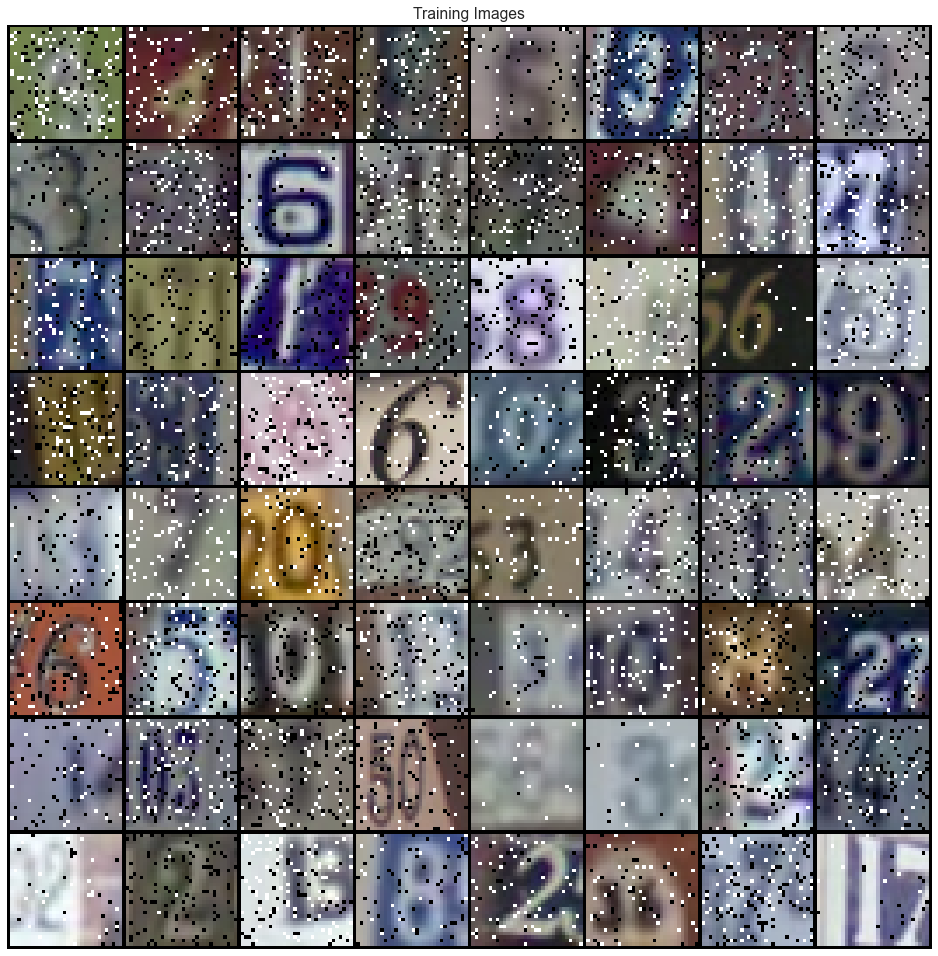

In [3]:
idx = np.random.randint(len(train_data['images']), size=64)

plt.figure(figsize=(17, 17))
plt.title('Training Images')
plt.imshow(make_grid(torch.tensor(train_data['images'][idx]).permute(0, 3, 1, 2), padding=1).permute(1, 2, 0) / 255)
plt.axis('off')
plt.show()

Первое что бросается в глаза &mdash; это наличие salt-and-pepper noise. Для борьбы с ним применим медианный фильтр. Далее для придания гладкости картинкам была попытка применить гауссовский фильтр, но как показала практика качество моделей получалось хуже, однако несколько моделей из стекинга были все же были обучены на картинках, обработанных медианным фильтром. 

По аналогии с гауссовским фильтром были эксперименты с изменением ядра медианного фильтра с 3 до 5, но они также не увенчались успехом, но были использованы в итоговом предсказании.

## Проверка на несбалансированность

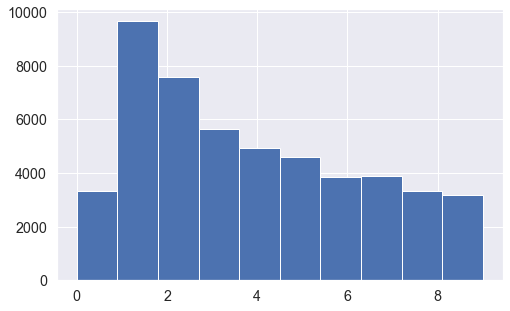

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(train_data['labels'])
plt.show()

Датасет более-менее сбалансирован. Была попытка использовать взвешенный лосс, где веса были обратно пропорциональны частоте встречаемости метки, но это приводило к худшему результату. Скорее всего использование весов нарушало распределение меток: мы "заставляли" модель делать более-менее равномерные предсказания, в то время как метки имели распределение, похожее на пуассоновское.

In [5]:
# weight = len(train_data['labels']) / np.unique(train_data['labels'], return_counts=True)[1]

## Обработка изображений и разбиение на train/val

In [6]:
train_data['images'] = process_images(train_data['images'], mb_kernel_size=3)
test_data['images'] = process_images(test_data['images'], mb_kernel_size=3)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=47)

## Создание dataloader

In [7]:
batch_size = 256
transform = transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)

train_dataset = DigitsDataset(train_data, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DigitsDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## Борьба с переобучением

Основой борьбы с переобучением послужили аугментации, такие как афинное преобразование, изменение контрастности, соляризация и выравание изображения. Также были проведены эксперименты с использованием l2-регуляризации и label smoothing, но они не дали значительных результатов.

## Выбор моделей

Первой моделью для экспериментов стала `resnet`, т.к. ее архитектуру уже приходилось реализовывать неоднократно. Единственное изменение, которое пришлось сделать это уменьшить stride c 2 до 1 у первого сверточного слоя, т.к. нет смысла уменьшать изображение 32x32 в 2 раза в самом начале сети (уже при написании отчета вспомнил, что также в начале присутствует maxpooling, его следовало тоже убрать, скорее всего это бы немного улучшело качество resnet моделей). 

Далее была использована модель `wide-resnet-28x10` из [статьи](https://arxiv.org/pdf/2010.01412v3.pdf), которая показала наилучший результат классификации на SVHN (впрочем, из оригинальной [статьи](https://arxiv.org/pdf/1605.07146.pdf) по wide-resnet лучше моделью на SVHN оакзалась wide-resnet-16x8). Под конец экспериментов ~захотелось чего-то экзотического~ в попытках разнообразить модели из стекинга была использована модель `inception-v4` и сочетание inception и resnet &mdash; `inception-resnet-v2`. По аналогии с resnet были удалены начальные слои, уменьшающие размер картинки.

Схематичное описание моделей можно найти в папке models_description.

# Обучение

Большинство моделей были обучены на 20 эпохах, в качестве лосса использовался кросс-энтропийный лосс, а в качестве оптимизатора всем извсестный Adam. Величина начального шага обучения была выбрана как 3e-4 (так называемая "золотая" величина для Adam, известная как Karpathy Constant, но это просто шутка). Шаг обучения уменьшался в (n + 1)/n раз каждые 10 шагов обучения, т.е. после 10 эпохи в 2 раза, после 20 &mdash; в 1.5 раза и т.д. (хотя шаг обучения следовало бы уменьшать чаще, хотя бы каждые 5 эпох)

In [8]:
n_epochs = 20

model = wide_resnet_28x10().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

epoch number: 20
time per epoch: 92.76s
val epoch accuracy: 0.95
train epoch accuracy: 0.97


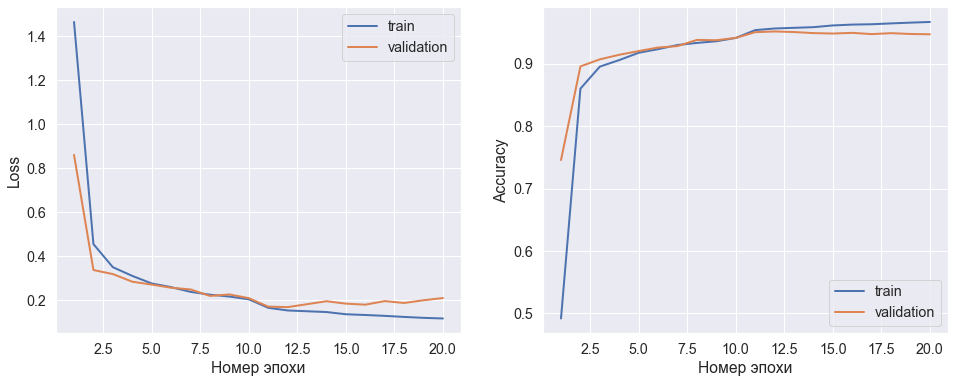

In [9]:
model, history = train_model(model, n_epochs, optimizer, criterion, train_dataloader, val_dataloader, device)

In [10]:
# model.save('./weights/wideresnet_19.pth')

## Метрики

Точное значение accuracy на валидации

In [11]:
y_true = np.concatenate([labels.numpy() for _, labels in val_dataloader])
y_pred = predict_on_dataloader(model, val_dataloader)

accuracy = (y_pred == y_true).mean()
print('accuracy: {}'.format(accuracy))

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy: 0.9565


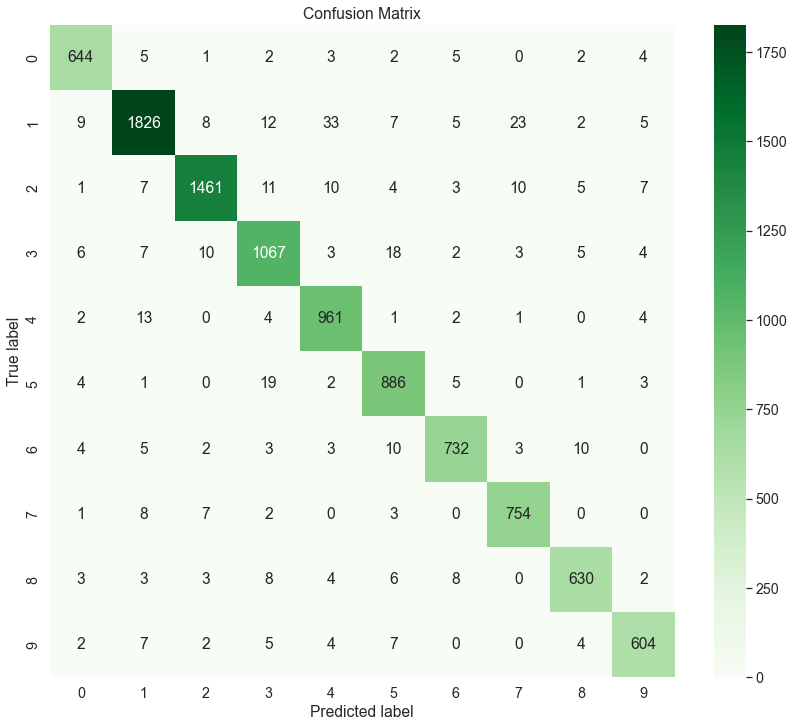

In [12]:
plot_confusion_matrix(y_true, y_pred)

Итак, у нас есть много моделей, обученных при различных условиях. Стакаем их!

In [13]:
models = {
    'wideresnet': wide_resnet_28x10(),
    'inception': inception_v4(),
    'inception-resnet': inception_resnet_v2(),
    'resnet34': resnet34(),
    'resnet50': resnet50(),
}

predictions = stack_models(models, val_dataloader, './weights', device)
y_pred = sps.mode(predictions, axis=1)[0][:, 0]

In [17]:
print('stacking accuracy: {}'.format((y_pred == y_true).mean()))

stacking accuracy: 0.9641


## Submission

In [18]:
test_data['labels'] = np.array([-1] * len(test_data['images'])) # создаем фиктивные метки для корректной работы DigitsDataset

test_dataset = DigitsDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size) 

del test_data['labels']

### Stacking

In [21]:
models = {
    'wideresnet': wide_resnet_28x10(),
    'inception': inception_v4(),
    'inception-resnet': inception_resnet_v2(),
    'resnet34': resnet34(),
    'resnet50': resnet50(),
}

predictions = stack_models(models, test_dataloader, './weights', device)
y_pred = sps.mode(predictions, axis=1)[0][:, 0]

In [22]:
write_solution('solution.csv', y_pred)

## Наиболее важные улучшения

* Медианный фильтр
* Аугментации
* Стекинг

### Private score: 0.96102 